In [1]:
#!pip install transformers tntorch -qqq

In [2]:
!nvidia-smi

Wed Dec 21 17:27:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1B:00.0 Off |                  Off |
|  0%   33C    P8    24W / 460W |    265MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1C:00.0 Off |                  N/A |
| 27%   

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [4]:
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm.auto import tqdm

%config InlineBackend.figure_format = "svg"
plt.rcParams["font.size"] = 20

In [5]:
model = AutoModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Let's take arbitrary parameter matrix.

In [6]:
device = 'cuda:0'
w = model.encoder.layer[0].intermediate.dense.weight.detach().to(device)

In [7]:
w.shape

torch.Size([3072, 768])

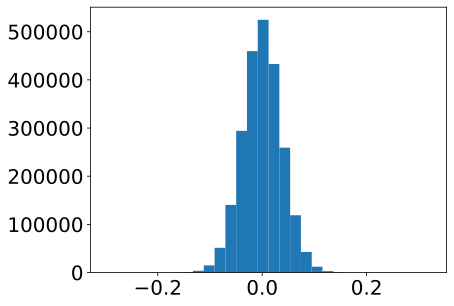

In [8]:
plt.hist(w.cpu().numpy().ravel(), bins=30)
plt.show()

In [9]:
u, s, vt = torch.linalg.svd(w, full_matrices=False)

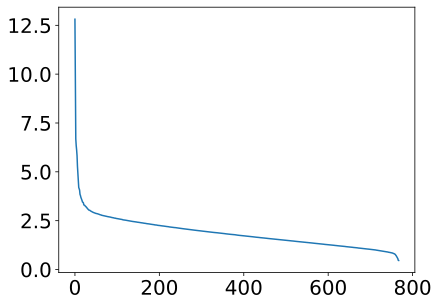

In [10]:
plt.plot(s.cpu())
plt.show()

It is of high rank, so naive svd should work badly.

Let's generate random weights, which will serve as "Fisher information".

In [11]:
torch.manual_seed(2222)
weight = torch.rand(*w.shape) ** 100
weight /= weight.max()

Weights are 
1. from 0 to 1 (important!!!)
2. mostly zero, rarely one

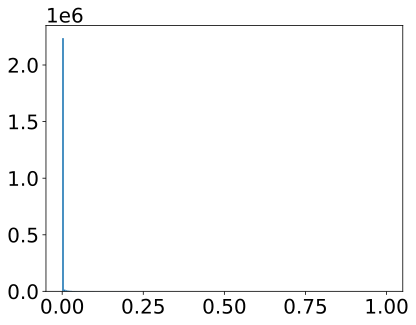

In [12]:
plt.hist(weight.numpy().ravel(), bins=200)
plt.show()

In [first article](https://arxiv.org/abs/2207.00112) authors sum elements of Fisher matrix by rows (or by columns -- maybe it should be `.sum(0)`, I'm not sure )

torch.Size([3072])


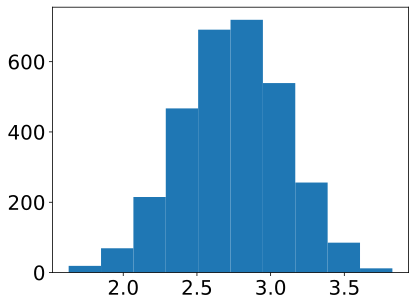

In [13]:
diag_weight = torch.sqrt(weight.sum(1))
print(diag_weight.shape)
plt.hist(diag_weight)
plt.show()

In [14]:
def weighted_frob(a, weight):
    return torch.sqrt(torch.sum(torch.square(a) * weight)).item()

In [15]:
def get_low_rank(w, k):
    u, s, vt = torch.linalg.svd(w, full_matrices=False)
    u = u[:, :k]
    s = s[:k]
    vt = vt[:k]
    return u, torch.diag(s) @ vt

In [16]:
def weighted_svd(w, rank, weight, n_iter=300):
    a, b = get_low_rank(w, rank)

    for _ in range(n_iter):
        a, b = get_low_rank(weight * w + (1 - weight) * (a @ b), rank)
    
    return a, b

In [17]:
def nesterov(w, k, weight, n_iter=300):
    prev_a, prev_b = get_low_rank(w, k)
    prev_x = prev_a @ prev_b
    
    a, b = get_low_rank(weight * w + (1 - weight) * (prev_a @ prev_b), k)
    x = a @ b
    
    for i in range(1, n_iter):
        v = x + (i - 1) / (i + 2) * (x - prev_x)

        a, b = get_low_rank(weight * w + (1 - weight) * v, k)
        
        prev_x = x
        x = a @ b

    return a, b

In [18]:
def anderson(w, k, weight, n_iter=300, buffer_size=10, regularization_coef=0.0):
    residual_buffer = []
    approximations_buffer = []
    
    device = w.device

    y = w.clone()
    a, b = get_low_rank(w, k)
    x = a @ b

    for i in range(n_iter):
        f = weight * w + (1 - weight) * x
        residual = (f - y).reshape(-1)
        
        residual_buffer.append(residual)
        approximations_buffer.append(f)

        r = len(residual_buffer)

        # shape (r, nm), if shape of w is (n, m)
        R = torch.stack(residual_buffer)
        alpha = torch.linalg.solve(R @ R.T + regularization_coef * torch.eye(r).to(device), torch.ones(r).to(device))
        alpha = alpha / alpha.sum()

        y = torch.sum(torch.stack(approximations_buffer) * alpha[:, None, None], dim=0)
        a, b = get_low_rank(y, k)
        x = a @ b

        if len(residual_buffer) >= buffer_size:
            residual_buffer = residual_buffer[1:]
        if len(approximations_buffer) >= buffer_size:
            approximations_buffer = approximations_buffer[1:]
    
    return a, b

In [19]:
svd_err = []
wsvd_err = []
wwsvd_err = []
nesterov_err = []
anderson_err = []

weight = weight.to(device)
diag_weight = diag_weight.to(device)

norm_w = weighted_frob(w, weight)

rank_range = range(10, 300, 20)

for k in tqdm(rank_range):
    print(k)
    # SVD
    a, b = get_low_rank(w, k)

    # SVD with weights from first article
    aa, bb = get_low_rank(torch.diag(diag_weight) @ w, k)
    aa = torch.diag(1 / diag_weight) @ aa

    # Weighted SVD from https://www.aaai.org/Papers/ICML/2003/ICML03-094.pdf
    aaa, bbb = weighted_svd(w, k, weight)

    na, nb = nesterov(w, k, weight)
    
    anderson_a, anderson_b = anderson(w, k, weight)
    
    svd_err.append(weighted_frob(w - a @ b, weight) / norm_w)
    wsvd_err.append(weighted_frob(w - aa @ bb, weight) / norm_w)
    wwsvd_err.append(weighted_frob(w - aaa @ bbb, weight) / norm_w)
    nesterov_err.append(weighted_frob(w - na @ nb, weight) / norm_w)
    anderson_err.append(weighted_frob(w - anderson_a @ anderson_b, weight) / norm_w)
    

  0%|          | 0/15 [00:00<?, ?it/s]

10
30
50
70
90
110
130
150
170
190
210
230
250
270
290


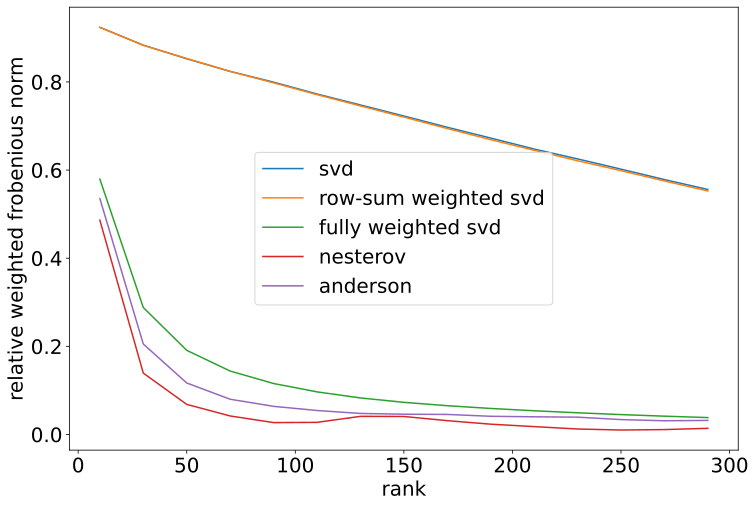

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(rank_range, svd_err, label="svd")
plt.plot(rank_range, wsvd_err, label="row-sum weighted svd")
plt.plot(rank_range, wwsvd_err, label="fully weighted svd")
plt.plot(rank_range, nesterov_err, label="nesterov")
plt.plot(rank_range, anderson_err, label="anderson")
plt.xlabel("rank")
plt.ylabel("relative weighted frobenious norm")
plt.legend()
plt.show()

Fully weighted SVD works better, as expected.

I expected row-sum weigthed SVD to be better, but it's not.
So either my expectations, or my implementation is wrong.

In [21]:
torch.manual_seed(2222)
weight = torch.rand(*w.shape) ** 100
weight += (torch.arange(1, 3073) / 3072)[:, None]
weight /= weight.max()

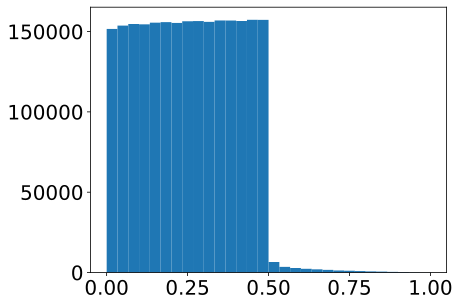

In [22]:
plt.hist(weight.numpy().ravel(), bins=30)
plt.show()

torch.Size([3072])


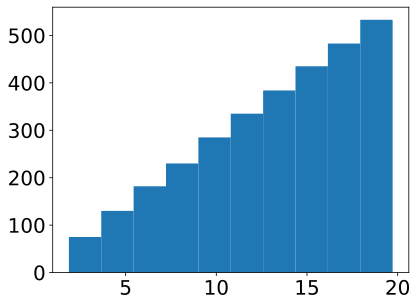

In [23]:
diag_weight = torch.sqrt(weight.sum(1))
print(diag_weight.shape)
plt.hist(diag_weight)
plt.show()

In [24]:
svd_err = []
wsvd_err = []
wwsvd_err = []
nesterov_err = []
anderson_err = []

weight = weight.to(device)
diag_weight = diag_weight.to(device)

norm_w = weighted_frob(w, weight)

rank_range = range(10, 300, 20)

for k in tqdm(rank_range):
    print(k)
    # SVD
    a, b = get_low_rank(w, k)

    # SVD with weights from first article
    aa, bb = get_low_rank(torch.diag(diag_weight) @ w, k)
    aa = torch.diag(1 / diag_weight) @ aa

    # Weighted SVD from https://www.aaai.org/Papers/ICML/2003/ICML03-094.pdf
    aaa, bbb = weighted_svd(w, k, weight)

    na, nb = nesterov(w, k, weight)
    
    anderson_a, anderson_b = anderson(w, k, weight)
    
    svd_err.append(weighted_frob(w - a @ b, weight) / norm_w)
    wsvd_err.append(weighted_frob(w - aa @ bb, weight) / norm_w)
    wwsvd_err.append(weighted_frob(w - aaa @ bbb, weight) / norm_w)
    nesterov_err.append(weighted_frob(w - na @ nb, weight) / norm_w)
    anderson_err.append(weighted_frob(w - anderson_a @ anderson_b, weight) / norm_w)
    

  0%|          | 0/15 [00:00<?, ?it/s]

10
30
50
70
90
110
130
150
170
190
210
230
250
270
290


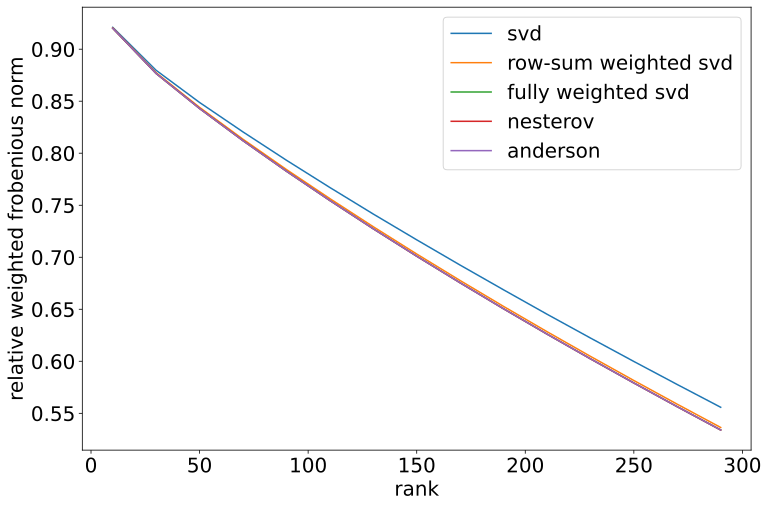

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(rank_range, svd_err, label="svd")
plt.plot(rank_range, wsvd_err, label="row-sum weighted svd")
plt.plot(rank_range, wwsvd_err, label="fully weighted svd")
plt.plot(rank_range, nesterov_err, label="nesterov")
plt.plot(rank_range, anderson_err, label="anderson")
plt.xlabel("rank")
plt.ylabel("relative weighted frobenious norm")
plt.legend()
plt.show()

Apparently, my expectations and my implementation was correct, but the results heavily depends on the distribution of weights in weighting matrix.

## Real Fisher information matrices

In [26]:
outer_weights = [np.load(f"fisher_matrices/figher_matrix_outer_layer_{i}.npy") for i in range(12)]
inter_weights = [np.load(f"fisher_matrices/fisher_matrix_inter_layer_{i}.npy") for i in range(12)]

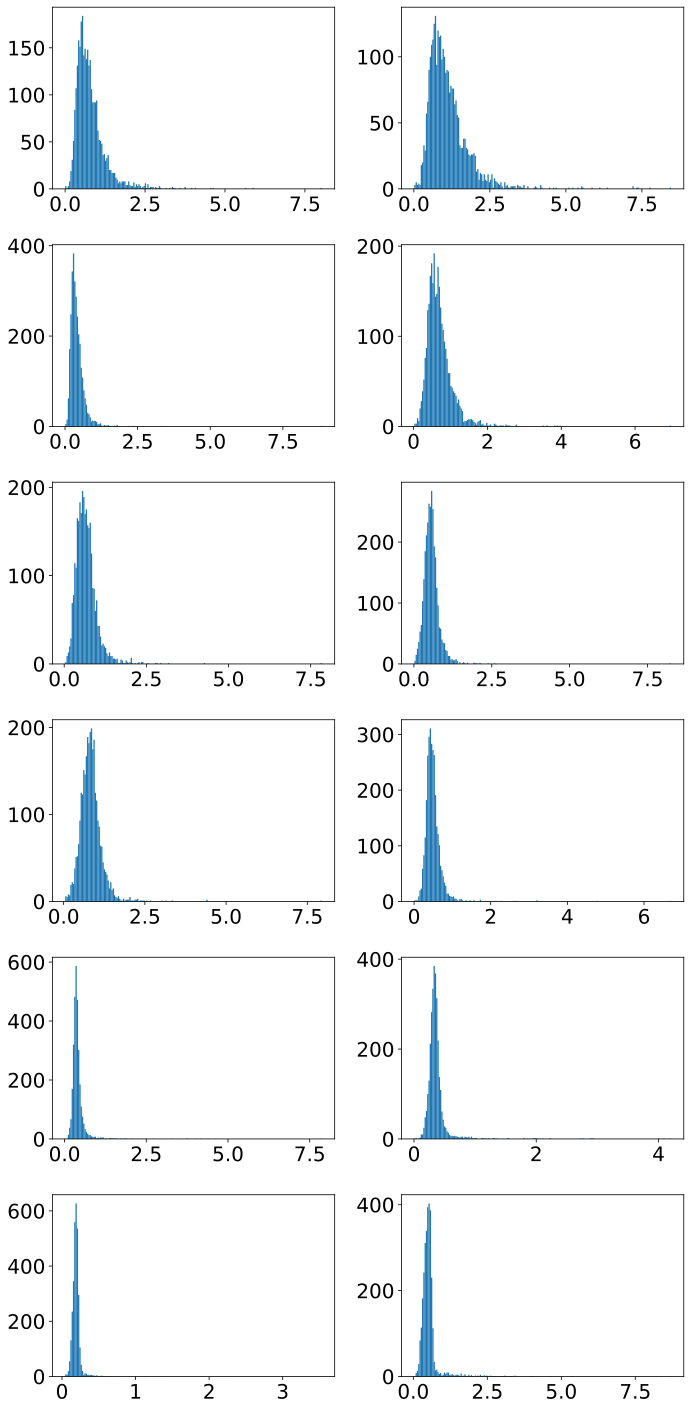

In [27]:
plt.figure(figsize=(10, 20))

for i, weight in enumerate(outer_weights):
    plt.subplot(6, 2, i + 1)
    plt.hist(np.sqrt(weight.sum(1)), bins=200)

plt.tight_layout()
plt.show()

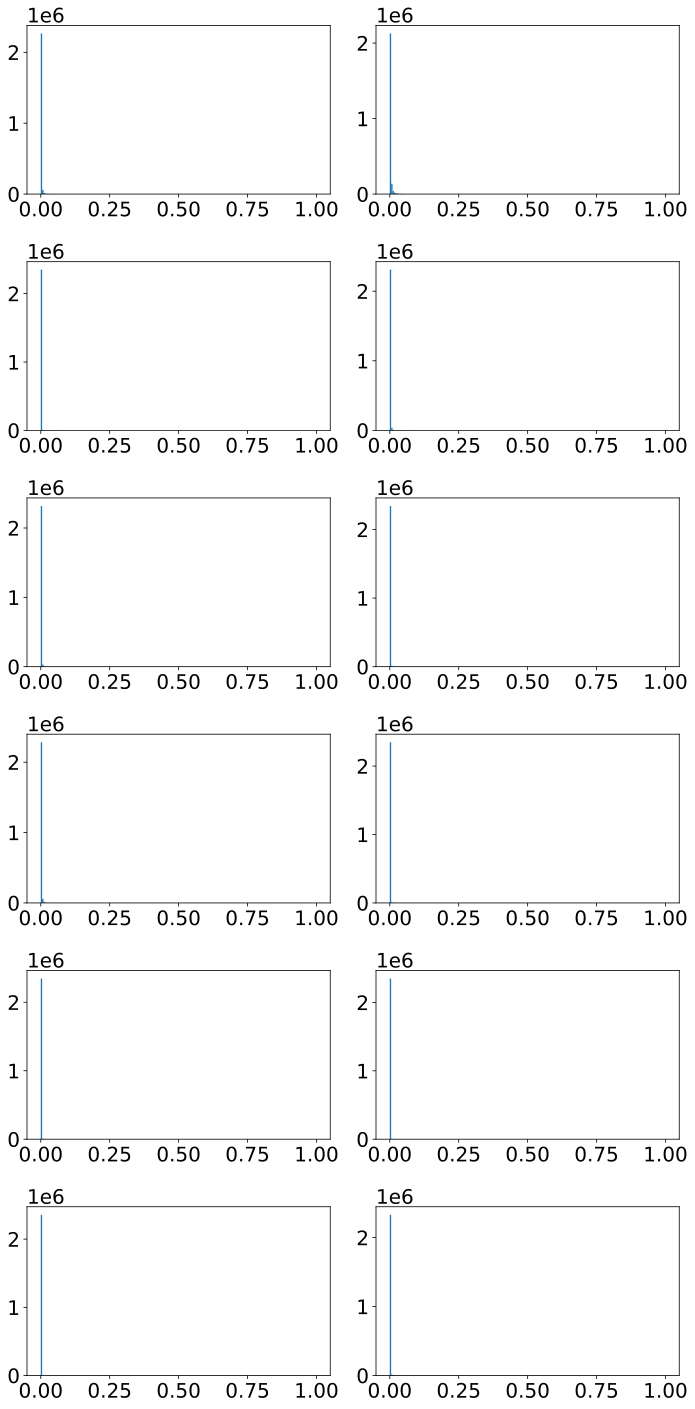

In [28]:
plt.figure(figsize=(10, 20))

for i, weight in enumerate(outer_weights):
    plt.subplot(6, 2, i + 1)
    plt.hist(weight.ravel(), bins=200)

plt.tight_layout()
plt.show()

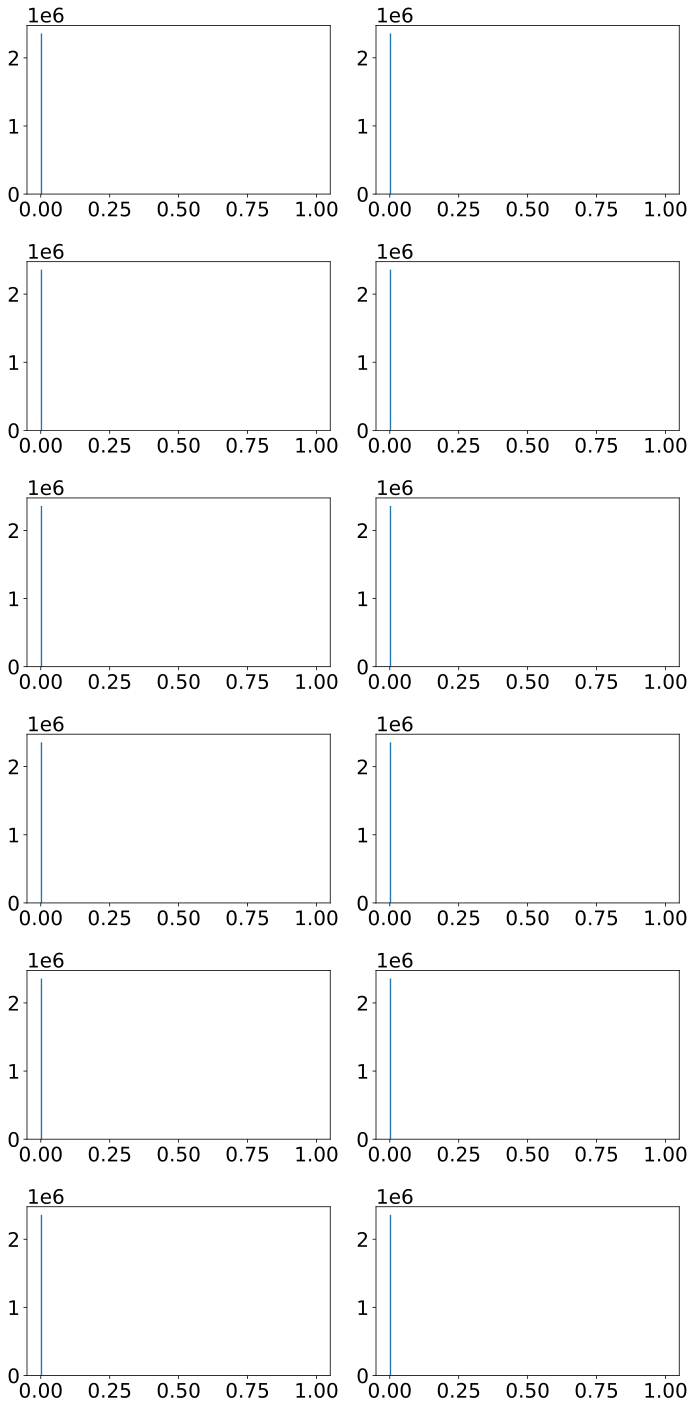

In [29]:
plt.figure(figsize=(10, 20))

for i, weight in enumerate(inter_weights):
    plt.subplot(6, 2, i + 1)
    plt.hist(weight.ravel(), bins=200)

plt.tight_layout()
plt.show()

In [30]:
device = 'cuda:0'
w = model.encoder.layer[6].intermediate.dense.weight.detach().to(device)
weight = inter_weights[6].T

In [31]:
w.shape, weight.shape

(torch.Size([3072, 768]), (3072, 768))

In [32]:
svd_err = []
wsvd_err = []
wwsvd_err = []
nesterov_err = []
anderson_err = []

l2svd_err = []
l2wsvd_err = []
l2wwsvd_err = []
l2nesterov_err = []
l2anderson_err = []

weight = torch.from_numpy(weight).to(device)
diag_weight = diag_weight.to(device)

norm_w = weighted_frob(w, weight)

def frob(w):
    return torch.linalg.norm(w, ord="fro")

l2_norm_w = frob(w)

rank_range = range(10, 300, 20)

for k in tqdm(rank_range):
    print(k)
    # SVD
    a, b = get_low_rank(w, k)

    # SVD with weights from first article
    aa, bb = get_low_rank(torch.diag(diag_weight) @ w, k)
    aa = torch.diag(1 / diag_weight) @ aa

    # Weighted SVD from https://www.aaai.org/Papers/ICML/2003/ICML03-094.pdf
    aaa, bbb = weighted_svd(w, k, weight)

    na, nb = nesterov(w, k, weight)
    
    anderson_a, anderson_b = anderson(w, k, weight)
    
    svd_err.append(weighted_frob(w - a @ b, weight) / norm_w)
    wsvd_err.append(weighted_frob(w - aa @ bb, weight) / norm_w)
    wwsvd_err.append(weighted_frob(w - aaa @ bbb, weight) / norm_w)
    nesterov_err.append(weighted_frob(w - na @ nb, weight) / norm_w)
    anderson_err.append(weighted_frob(w - anderson_a @ anderson_b, weight) / norm_w)
    
    
    l2svd_err.append(frob(w - a @ b) / l2_norm_w)
    l2wsvd_err.append(frob(w - aa @ bb) / l2_norm_w)
    l2wwsvd_err.append(frob(w - aaa @ bbb) / l2_norm_w)
    l2nesterov_err.append(frob(w - na @ nb) / l2_norm_w)
    l2anderson_err.append(frob(w - anderson_a @ anderson_b) / l2_norm_w)
    

  0%|          | 0/15 [00:00<?, ?it/s]

10
30
50
70
90
110
130
150
170
190
210
230
250
270
290


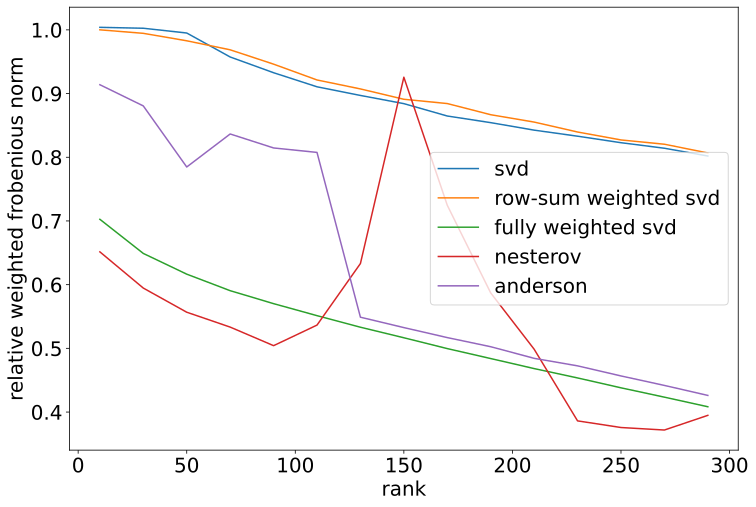

In [33]:
plt.figure(figsize=(12, 8))
plt.plot(rank_range, svd_err, label="svd")
plt.plot(rank_range, wsvd_err, label="row-sum weighted svd")
plt.plot(rank_range, wwsvd_err, label="fully weighted svd")
plt.plot(rank_range, nesterov_err, label="nesterov")
plt.plot(rank_range, anderson_err, label="anderson")
plt.xlabel("rank")
plt.ylabel("relative weighted frobenious norm")
plt.legend()
plt.show()

In [34]:
l2svd_err = [e.item() for e in l2svd_err]
l2wsvd_err = [e.item() for e in l2wsvd_err]
l2wwsvd_err = [e.item() for e in l2wwsvd_err]
l2nesterov_err = [e.item() for e in l2nesterov_err]
l2anderson_err = [e.item() for e in l2anderson_err]


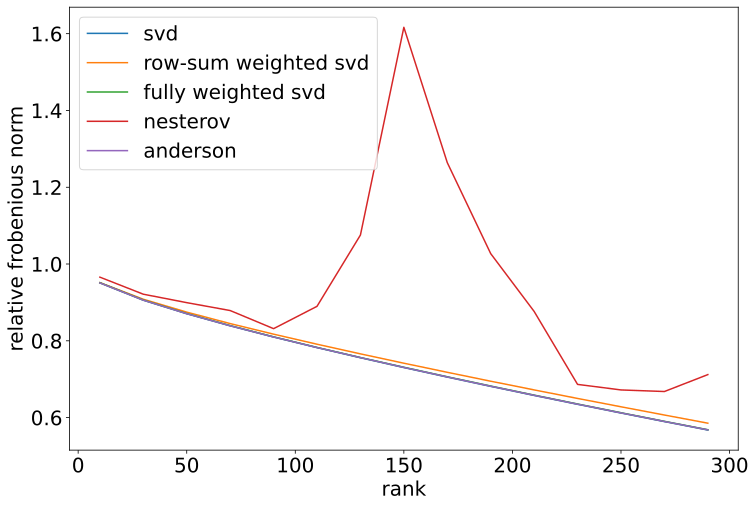

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(rank_range, l2svd_err, label="svd")
plt.plot(rank_range, l2wsvd_err, label="row-sum weighted svd")
plt.plot(rank_range, l2wwsvd_err, label="fully weighted svd")
plt.plot(rank_range, l2nesterov_err, label="nesterov")
plt.plot(rank_range, l2anderson_err, label="anderson")
plt.xlabel("rank")
plt.ylabel("relative frobenious norm")
plt.legend()
plt.show()

## Plot exp results

In [36]:
import pandas as pd

In [37]:
path = "../results.csv"
df = pd.read_csv(path)

In [38]:
df.loc[df.model.str.contains("other"), "model"] = df.loc[df.model.str.contains("other"), "model"].str.replace("other_", "")
df.loc[df.model.str.contains("plus"), "model"] = df.loc[df.model.str.contains("plus"), "model"].str.replace("plus", "row-sum-weighted-svd")

In [39]:
datasets = ("cola", "stsb")
methods = ("row-sum-weighted-svd", "fwsvd_weighted-svd", "anderson", "nesterov", "_svd")
method2title = {
    "row-sum-weighted-svd": "FWSVD",
    "fwsvd_weighted-svd": "honest weighted low-rank",
    "anderson": "anderson",
    "nesterov": "nesterov",
    "_svd": "SVD"
}
exp2score = {}

for dataset in datasets:
    for method in methods:
        values = df[df.model.str.contains(dataset) & df.model.str.contains(method)].score.values
        exp2score[(dataset, method)] = [0] + list(values)

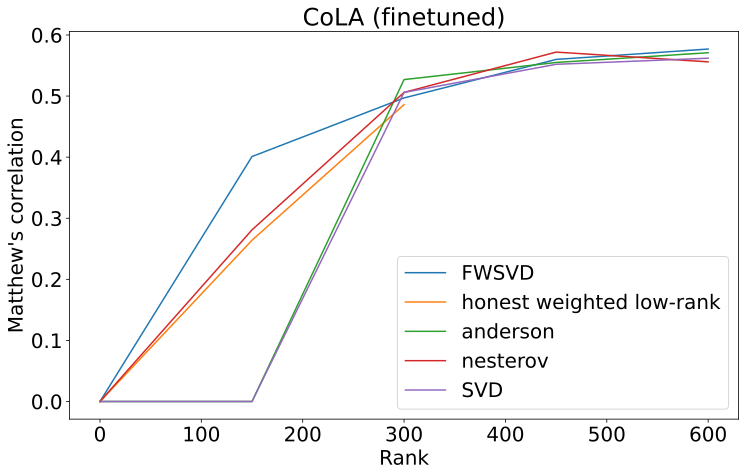

In [40]:
ranks = (0, 150, 300, 450, 600)

plt.figure(figsize=(12, 7))

for m in methods:
    score = exp2score[("cola", m)]
    plt.plot(ranks[:len(score)], score, label=method2title[m])

plt.ylabel("Matthew's correlation")
plt.xlabel("Rank")
plt.title("CoLA (finetuned)", fontsize=24)
plt.legend()
plt.savefig("../images/cola_finetune.pdf")
plt.show()

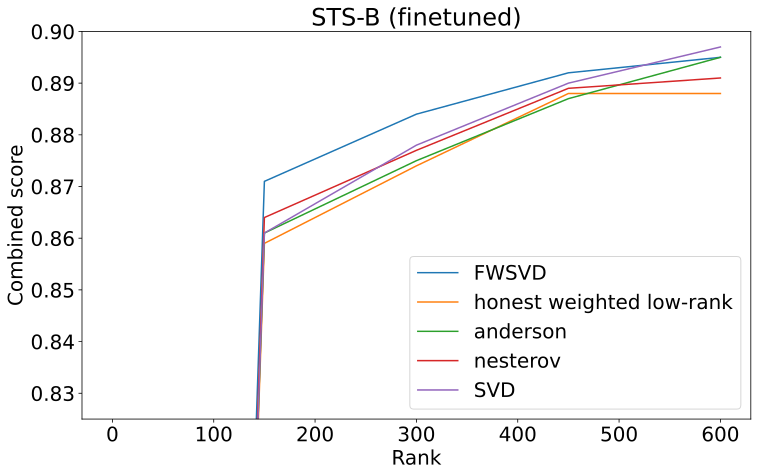

In [41]:
plt.figure(figsize=(12, 7))

for m in methods:
    score = exp2score[("stsb", m)]
    plt.plot(ranks[:len(score)], score, label=method2title[m])

plt.ylabel("Combined score")
plt.xlabel("Rank")
plt.title("STS-B (finetuned)", fontsize=24)
plt.ylim(0.825, 0.9)
plt.legend()
plt.savefig("../images/stsb_finetune.pdf")
plt.show()

In [42]:
path = "../no_finetune_results.csv"
df = pd.read_csv(path, header=None)

In [43]:
df.columns = ["model", "score"]

In [44]:
df.loc[df.model.str.contains("other"), "model"] = df.loc[df.model.str.contains("other"), "model"].str.replace("other_", "")
df.loc[df.model.str.contains("plus"), "model"] = df.loc[df.model.str.contains("plus"), "model"].str.replace("plus", "row-sum-weighted-svd")

In [45]:
df = df.sort_values("model")

In [46]:
datasets = ("cola", "stsb")
methods = ("row-sum-weighted-svd", "fwsvd_weighted-svd", "anderson", "nesterov", "_svd")

exp2score = {}

for dataset in datasets:
    for method in methods:
        values = df[df.model.str.contains(dataset) & df.model.str.contains(method)].score.values
        exp2score[(dataset, method)] = [0] + list(values)

In [47]:
fwsvd_names = ['bert-base-uncased-3epoch_fwsvd_150_cola', 'bert-base-uncased-3epoch_fwsvd_300_cola', 'bert-base-uncased-3epoch_fwsvd_450_cola', 'bert-base-uncased-3epoch_fwsvd_600_cola']
df[df.model.isin(fwsvd_names)].score.tolist()

[0.0, 0.3780008838555714, 0.5583884861093951, 0.5752393119535992]

In [48]:
exp2score[("cola", "row-sum-weighted-svd")] = [0] + df[df.model.isin(fwsvd_names)].score.tolist()

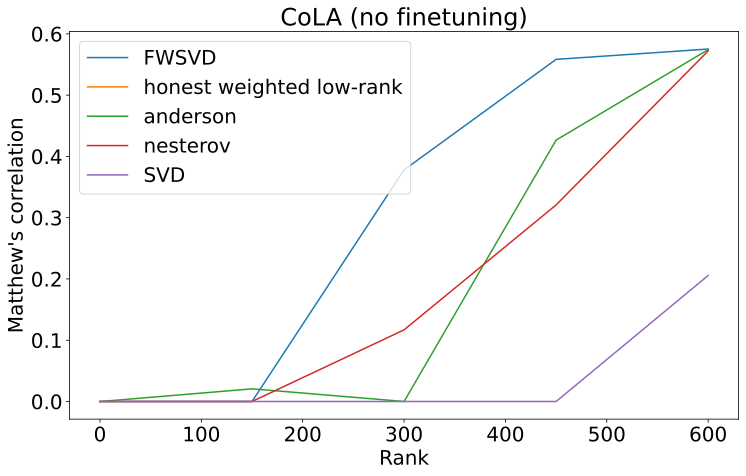

In [49]:
ranks = (0, 150, 300, 450, 600)

plt.figure(figsize=(12, 7))

for m in methods:
    score = exp2score[("cola", m)]
    plt.plot(ranks[:len(score)], score, label=method2title[m])

plt.ylabel("Matthew's correlation")
plt.xlabel("Rank")
plt.title("CoLA (no finetuning)", fontsize=24)
plt.legend()
plt.savefig("../images/cola_no_finetuning.pdf")
plt.show()

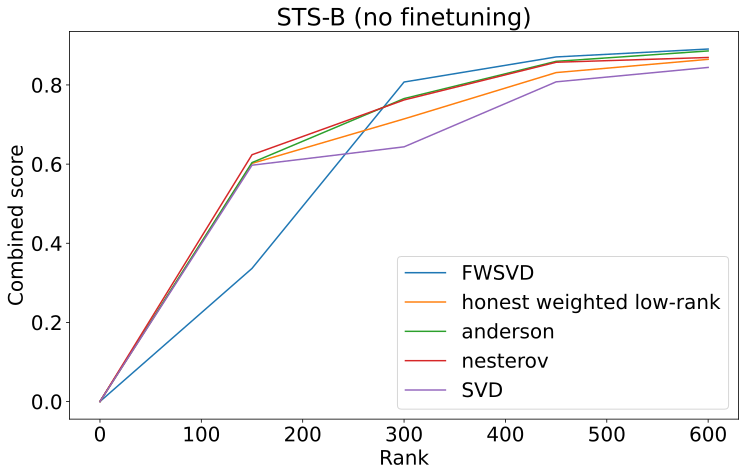

In [50]:
plt.figure(figsize=(12, 7))

for m in methods:
    score = exp2score[("stsb", m)]
    plt.plot(ranks[:len(score)], score, label=method2title[m])

plt.ylabel("Combined score")
plt.xlabel("Rank")
plt.title("STS-B (no finetuning)", fontsize=24)
plt.legend()
plt.savefig("../images/stsb_no_finetuning.pdf")
plt.show()

In [51]:
path = "../results.csv"
df = pd.read_csv(path)